In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


In [3]:
def function_2d(x,y):
    term_sqrt = np.sqrt(x*x+y*y)
    term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
    term2 = (1/5)*np.cos(10*term_sqrt)
    term3 = y/2 - 0.3

    label = term1 + term2 + term3

    return label

def generate_data(dim):
    x = np.linspace(-1, 1, dim)
    y = np.linspace(-1, 1, dim)
    xx, yy = np.meshgrid(x,y)
    zz = function_2d(xx,yy)
    data_1 = xx.reshape(-1,1)
    data_2 = yy.reshape(-1,1)
    label = zz.reshape(-1,1)
    dataset = np.hstack((data_1, data_2))
    dataset = np.hstack((dataset, label))
    
    return dataset

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x,y)
zz = function_2d(xx,yy)
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')
surf.set_clim(-1.0, 1.0)
ax.view_init(30,-60)
ax.set_zticks([-1,1])
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
plt.show()

In [5]:
class Mydataset(torch.utils.data.Dataset):
    
    def __init__(self, dataX_np , dataY_np):
        self.data_X = dataX_np.astype(np.float32)
        self.data_Y = dataY_np.astype(np.float32)
        
        print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")
    
    def __getitem__(self, index):
        batch = self.data_X[index]
        target = self.data_Y[index]
        
        return batch, target
        
    def __len__(self):
        return len(self.data_X)

In [6]:
dataset = generate_data(100)

In [7]:
x = dataset[:, :2]
y = dataset[:,2:]

# train-temp 분리 (7:3)
x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3, shuffle=True)

# temp 에서 validation-test 분리 3 -> 1.5:1.5
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,shuffle=True)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


In [91]:
class SimpleMLP(nn.Module):
    
    def __init__(self, inp_ = 2, output_ = 1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(2, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512,256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x) 
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x) 
        x = self.fc6(x)
        x = F.relu(x) 
        x = self.fc7(x)
        x = F.relu(x) 
        x = self.fc8(x)
        
        return x

In [92]:
batch_size = 100000
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


##Training

In [93]:
from statistics import mean
import time

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    train_losses = []
    valid_losses = []
    test_losses = []
    
    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        model.train()
        batch_losses = []

        for samples, labels in train_loader:
            
            samples = samples.to(device)
            labels = labels.to(device)

            optimizer_.zero_grad()

            outputs = model(samples)

            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            loss.backward()

            optimizer_.step()

        train_losses.append(mean(batch_losses))
        model.eval()
        with torch.no_grad():

            for samples, labels in valid_loader:

                samples = samples.to(device)
                labels = labels.to(device)

                outputs = model(samples)

                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for samples, labels in test_loader:

                samples = samples.to(device)
                labels = labels.to(device)

                outputs = model(samples)

                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

        if (epoch) % 1000 ==0:
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}] [Validation loss : {valid_rec}][Test loss : {test_rec}] [curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        scheduler_.step()


    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")

    return train_losses, valid_losses, test_losses

In [94]:
model = SimpleMLP()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

----------------------------------------------------------------------------
Epoch 1000  /  10000
	 [Train loss : 0.00108] [Validation loss : 0.0011][Test loss : 0.00112] [curr LR = [1.953125e-06]],[elapsed_time = 94sec] 
Epoch 2000  /  10000
	 [Train loss : 0.00106] [Validation loss : 0.00108][Test loss : 0.0011] [curr LR = [1.9073486328125e-09]],[elapsed_time = 188sec] 
Epoch 3000  /  10000
	 [Train loss : 0.00106] [Validation loss : 0.00108][Test loss : 0.0011] [curr LR = [1.862645149230957e-12]],[elapsed_time = 279sec] 
Epoch 4000  /  10000
	 [Train loss : 0.00106] [Validation loss : 0.00108][Test loss : 0.0011] [curr LR = [1.8189894035458565e-15]],[elapsed_time = 373sec] 
Epoch 5000  /  10000
	 [Train loss : 0.00106] [Validation loss : 0.00108][Test loss : 0.0011] [curr LR = [1.7763568394002505e-18]],[elapsed_time = 465sec] 
Epoch 6000  /  10000
	 [Train loss : 0.00106] [Validation loss : 0.00108][Test loss : 0.0011] [curr LR = [1.734723475976807e-21]],[elapsed_time = 557sec] 
Epo

In [95]:
def plot_result(train_loss, val_loss, test_loss):
    plt.figure(figsize=(20,8))
    plt.plot(train_loss, label='Train Loss', linewidth='3')
    plt.plot(val_loss, label='Validation Loss', linewidth='3')
    plt.plot(test_loss, label='Test Loss', linewidth='3')
    plt.grid()
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.legend()
    plt.rc('legend', fontsize=15)
    plt.xlabel('Number of Eopch')
    plt.ylabel('MSE Loss')
    plt.rc('axes', labelsize=17)

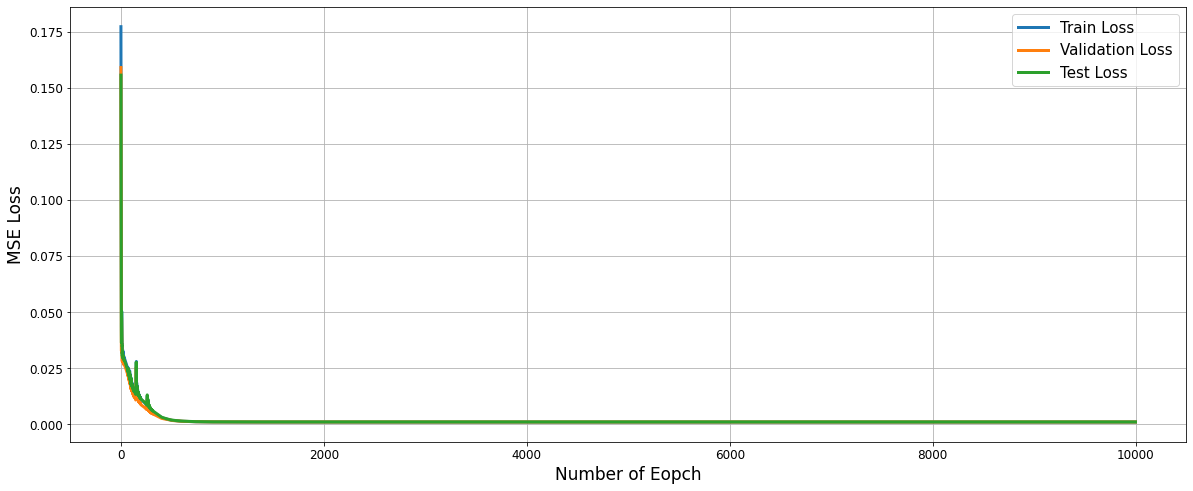

In [96]:
plot_result(train_losses, valid_losses, test_losses)

In [97]:
def visual_graph(model):
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xx,yy = np.meshgrid(x,y)
    xx = xx.reshape(-1,1)
    yy = yy.reshape(-1,1)
    inp_np = np.hstack((xx,yy))
    inp_tensor = torch.Tensor(inp_np)
    inp_tensor = inp_tensor.to(device)
    zz = model(inp_tensor)
    pred_output = zz.detach().cpu().numpy()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    xx = xx.reshape(100,100)
    yy = yy.reshape(100,100)
    pred_output = pred_output.reshape(100,100)
    surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis')
    surf.set_clim(-1.0, 1.0)
    ax.view_init(30,-60)
    ax.set_zticks([-1,1])
    ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
    plt.tight_layout()
    plt.show()

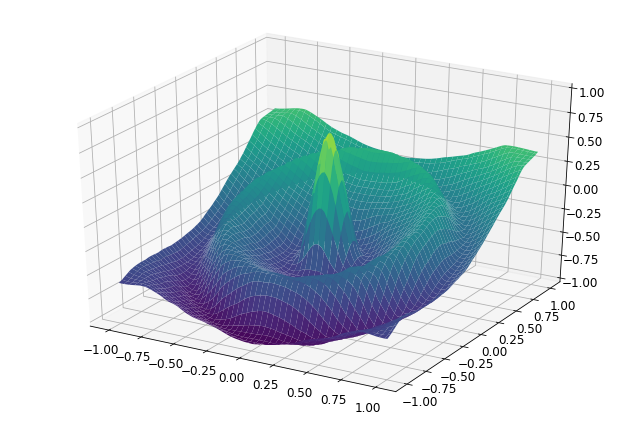

In [98]:
visual_graph(model)